In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import warnings
import seaborn as sns
import matplotlib.colors as clr
from scipy.stats import gaussian_kde


warnings.filterwarnings("ignore")

Load in the adata

In [2]:
adata = sc.read_h5ad('/mnt/sata1/Dhruv_Analysis_1/2025_10_31_Clone13/combined/final_adata.h5ad')

adata.obs['Subtype'] = adata.obs['resolvi_predicted']

In [3]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [4]:
import scipy.sparse as sp

gidx = adata.var_names.get_loc('Xist')
X = adata.X
if sp.issparse(X):
    mask = X[:, gidx].toarray().ravel() > 0  # safe for sparse
else:
    mask = X[:, gidx] > 0

adata_xist = adata[mask].copy()
print(adata.obs.shape)
print(adata_xist.obs.shape)

p14_Xist_adata = adata_xist[adata_xist.obs['Subtype'].isin(['Cd8_T-Cell_P14', 'Cd8_T-Cell_ab+'])]

(674090, 36)
(7422, 36)


In [5]:
adata = p14_Xist_adata

In [6]:
adata.obs["Subtype"].value_counts()

Subtype
Cd8_T-Cell_P14    1327
Cd8_T-Cell_ab+     492
Name: count, dtype: int64

In [7]:
zissou = [
    "#3A9AB2",
    "#6FB2C1",
    "#91BAB6",
    "#A5C2A3",
    "#BDC881",
    "#DCCB4E",
    "#E3B710",
    "#E79805",
    "#EC7A05",
    "#EF5703",
    "#F11B00",
]

colormap = clr.LinearSegmentedColormap.from_list("Zissou", zissou)
colormap_r = clr.LinearSegmentedColormap.from_list("Zissou", zissou[::-1])

In [8]:
adata.obs["batch"].unique()

['batch_1', 'batch_2']
Categories (2, object): ['batch_1', 'batch_2']

In [9]:
batches = {
    "batch_1": {"x": 6200, "y": 6200},
    "batch_2": {"x": 5800, "y": 5500},
}

In [10]:
# Functions to help with the IMAPS
def scatter_with_gaussian_kde_weights(ax, x, y, weights, **kwargs):
    """
    Plots a scatter plot colored by gaussian kde estimates.

    Parameters:
    - ax (matplotlib ax): The ax on which to plot the scatter plot.
    - x (np.array): The x values to perform the gaussian kde and scattering on.
    - y (np.array): The y values to perform the gaussian kde and scattering on.
    - weights (np.array): The weights to use for the gaussian kde.
    - **kwargs: Additional keyword arguments to pass to the scatter function.

    Returns:
    - None
    """

    xy = np.vstack([x, y])
    z = gaussian_kde(xy, weights=weights)(xy)

    ax.scatter(x, y, c=z, **kwargs)


# Custom biexponential transformation. Returns x coordinates that have been transformed
def transformation(x, a=0.1, b=0.1, c=0.5, d=2.5, f=4, w=1):
    x = np.array(x)
    return a * np.exp(b * ((x - w))) - c * np.exp(-d * (x - w)) + f


def draw_gates(ax, gates, transformation, type="edge"):
    """
    Draws IMAP gates on a matplotlib ax.

    Parameters:
    - ax (matplotlib ax): The ax on which to draw the gates.
    - gates (dict): A dictionary containing the gates to draw.
    - transformation (function): A function to transform the x values of the gates.
    - type (str): The type of gate to draw. Can be "fill" or "edge".

    Returns:
    - None
    """
    from matplotlib.patches import Polygon

    for gate in gates:
        # Apply transformation to x values
        points = [
            [transformation(element[0])] + element[1:]
            for element in gates[gate]["edges"]
        ]

        if type == "fill":
            p = Polygon(points, facecolor=gates[gate]["fill"], edgecolor="none")
            ax.add_patch(p)
        elif type == "edge":
            p = Polygon(points, facecolor="none", edgecolor="#222222")
            ax.add_patch(p)

            ax.text(
                transformation(gates[gate]["label_position"]["x"]),
                gates[gate]["label_position"]["y"],
                gate,
                fontsize=6,
                color="#222222",
            )

In [11]:
# Coordinates of the gates for only Top and Crypt
gates = {
    "Top": {
        "edges": [
            [0.055, 0.555],
            [6, 0.555],
            [6, 1.03],
            [0.055, 1.03],
        ],
        "label_position": {"x": 0.1, "y": 0.9},
        "fill": "#3A9AB244",
        "stroke": "#3A9AB2",
    },
    "Crypt": {
        "edges": [
            [0.055, 0.545],
            [6, 0.545],
            [6, 0.295],
            [0.335, 0.15],
            [0.055, 0.15]
        ],
        "label_position": {"x": 0.5, "y": 0.3},
        "fill": "#F11B0044",
        "stroke": "#F11B00",
    },
    "Muscularis": {
        "edges": [
            [0.34, 0.15], 
            [6, 0.29], 
            [6, .15], 
        ],
        "label_position": {"x": 0.6, "y": 0.2},
        "fill": "#BDC88155",
        "stroke": "#BDC881",
    },
}

In [12]:
# Create subplots
def plot_imaps(
    adata,
    batches,
    genes,
    ax_ticks=[0.15, 0.3, 0.6, 1, 6],
    transformation=transformation,
    gates=gates,
    dpi=100,
):
    """
    Plots IMAPs for a given set of batches and genes.

    Parameters:
    - adata (anndata): The anndata object containing the cells to plot.
    - batches (list): A list of batches to plot.
    - genes (list): A list of genes to weight the IMAPs by
    - ax_ticks (list): A list of x-axis ticks.
    - transformation (function): A function to transform the x values of the gates.
    - gates (dict): A dictionary containing the gates to plot.
    - dpi (int): The dpi of the plot.

    Returns:
    - None
    """
    fig = plt.figure(figsize=(3 * len(genes), 3 * len(batches)), dpi=dpi)

    # Apply transformation
    adata.obs["epithelial_distance_transformed"] = transformation(
        adata.obs["epithelial_distance"]
    )

    for col, gene in enumerate(genes):
        print("Plotting value: " + str(gene))
        # Iterate over batches
        for i, bt in enumerate(batches):
            sub_adata = adata[adata.obs["batch"] == bt]

            if gene == "Distribution":
                gene_expression = np.ones(len(sub_adata))
            else:
                gene_expression = np.array(
                    sub_adata[:, sub_adata.var.index == gene].X.flatten()
                )

            ax = fig.add_subplot(len(batches), len(genes), i * len(genes) + 1 + col)

            # Draw gates filled in background
            draw_gates(ax, gates=gates, transformation=transformation, type="fill")

            # Draw the density lines
            sns.kdeplot(
                data=sub_adata.obs,
                x="epithelial_distance_transformed",
                y="crypt_villi_axis",
                ax=ax,
                weights=gene_expression,
                color="#444444",
                linewidths=0.5,
            )

            # Colored scatter plot
            scatter_with_gaussian_kde_weights(
                ax=ax,
                x=sub_adata.obs["epithelial_distance_transformed"],
                y=sub_adata.obs["crypt_villi_axis"],
                weights=gene_expression,
                s=5,
                cmap="viridis" if gene == "Distribution" else colormap,
            )

            # Transform the tick labels and set them
            ax.set_xticks(transformation(ax_ticks))
            ax.set_xticklabels(ax_ticks)

            # Label the axes
            ax.set_xlabel("Epithelial Axis")
            ax.set_ylabel("Crypt-Villi Axis")

            ax.set_ylim(-0.02, 1.05)

            # Add a title
            if i == 0:
                ax.set_title(f"{gene}")
            else:
                ax.set_title(f"")
            draw_gates(ax, gates=gates, transformation=transformation)

    fig.tight_layout()

Figure 2h

In [13]:
'Gzma' in adata.var.index

True

Plotting value: Gzma
Plotting value: Gzmb
Plotting value: Itgae
Plotting value: Tcf7


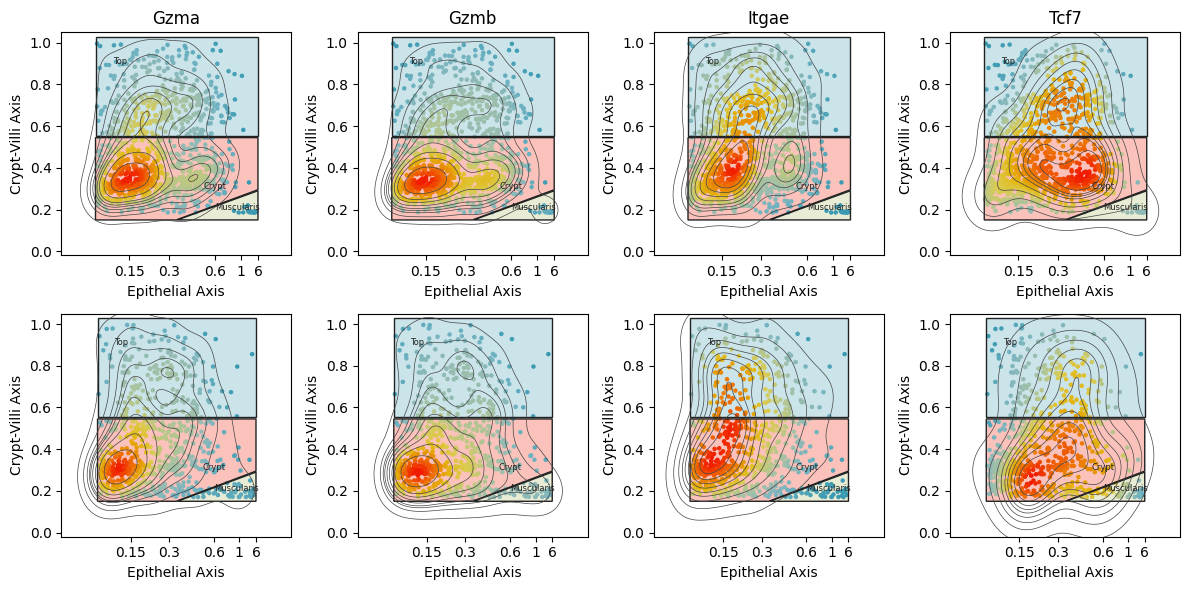

In [14]:
plot_imaps(
    adata,
    ["batch_1", "batch_2"],
    genes=["Gzma", "Gzmb", "Itgae", "Tcf7"],
)

In [15]:
adata.obs['Subtype'].value_counts()

Subtype
Cd8_T-Cell_P14    1327
Cd8_T-Cell_ab+     492
Name: count, dtype: int64

Figure 2i

In [16]:
adata_p14 = adata[adata.obs["Subtype"] == "Cd8_T-Cell_P14"]

In [17]:
def classify_cells(adata, gates, transformation=transformation):
    """
    Classify cells based on the IMAP gates.

    Parameters:
    - adata (anndata): The anndata object containing the cells to classify.
    - gates (dict): A dictionary containing the gates to classify the cells with.
    - transformation (function): A function to transform the x values of the gates.

    Returns:
    - result (geopandas dataframe): A geopandas dataframe containing the classified cells.
    """
    from shapely.geometry import Point
    from shapely.geometry.polygon import Polygon
    import geopandas as gpd

    adata.obs["epithelial_distance_transformed"] = transformation(
        adata.obs["epithelial_distance"]
    )
    adata.obs["gate"] = False

    print("Creating polygons")
    polygons = {}
    for gate in gates:
        # Apply transformation to x values
        points = [
            [transformation(element[0])] + element[1:]
            for element in gates[gate]["edges"]
        ]
        polygons[gate] = Polygon(points)
    polygons = gpd.GeoSeries(polygons)
    gpd_poly = gpd.GeoDataFrame({"gates": polygons}, geometry="gates")

    print("Creating cells")
    cells = gpd.GeoSeries.from_xy(
        adata.obs["epithelial_distance_transformed"], adata.obs["crypt_villi_axis"]
    )
    gpd_cells = gpd.GeoDataFrame({"cells": cells}, geometry="cells")

    print("Joining cells and polygons")
    result = gpd.sjoin(
        gpd_cells,
        gpd_poly,
        how="left",
    )
    return result


def get_mean_expression(adata, genes):
    """
    Calculate the mean expression of specified genes for each batch and gate in the provided AnnData object.

    Parameters:
    - adata (AnnData): Annotated data matrix with observations (rows) and variables (columns).
    - genes (list): A list of gene names for which mean expression is calculated.

    Returns:
    - pd.DataFrame: A DataFrame containing mean expression values for each gene, batch, and gate.
    """
    import re

    keys = genes + ["batch", "gate"]
    df = sc.get.obs_df(adata, keys=keys)
    grouped = (
        df.groupby(["batch", "gate"])
        .mean()
        .join(df.groupby(["batch", "gate"]).size().rename("group_size"))
        .reset_index()
    )
    grouped["Day"] = [re.findall(r"\d+", b)[0] for b in grouped["batch"]]

    # Melt into a longer form
    grouped = pd.melt(
        grouped,
        id_vars=["batch", "Day", "gate", "group_size"],
        var_name="gene",
        value_name="expression",
    )
    return grouped


def get_scaled_mean_expression(adata, genes):
    """
    Calculate the scaled mean expression of specified genes for each batch and gate in the provided AnnData object.

    Parameters:
    - adata (AnnData): Annotated data matrix with observations (rows) and variables (columns).
    - genes (list): A list of gene names for which scaled mean expression is calculated.

    Returns:
    - pd.DataFrame: A DataFrame containing scaled mean expression values for each gene, batch, and gate.
    """
    grouped = get_mean_expression(adata=adata, genes=genes)
    # Group the DataFrame by gene
    gene_groups = grouped.groupby("gene")

    # Apply the scaling function to each group
    def scale_group(group):
        gene_min = group["expression"].min()
        gene_max = group["expression"].max()
        group["expression"] = (group["expression"] - gene_min) / (gene_max - gene_min)
        return group

    df_scaled = gene_groups.apply(scale_group)
    df_scaled = df_scaled.reset_index(drop=True)

    return df_scaled

In [ ]:
classification = classify_cells(adata, gates)
adata.obs["gate"] = classification["index_right"]

Creating polygons
Creating cells
Joining cells and polygons


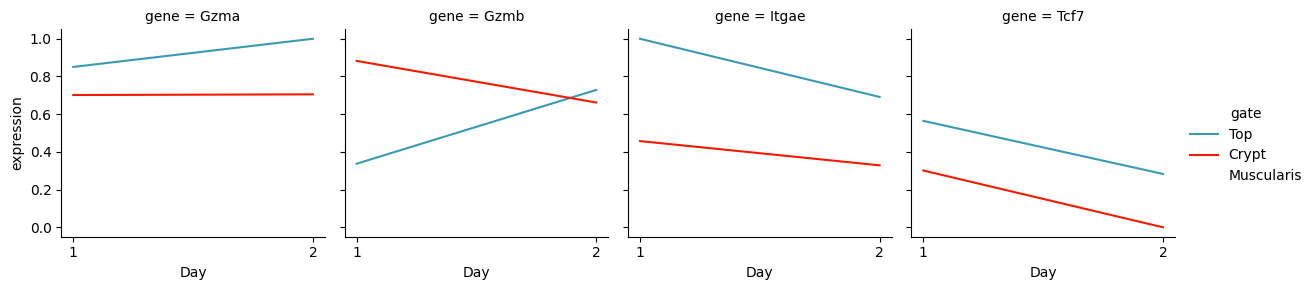

In [ ]:
df = get_scaled_mean_expression(adata, ["Tcf7", "Itgae", "Gzma", "Gzmb"])
df = df[df["group_size"] >= 50]
gate_order = list(gates)
df["gate"] = (
    df["gate"].astype("category").cat.set_categories(gate_order, ordered=True)
)
g = sns.FacetGrid(
    df,
    hue="gate",
    col="gene",
    col_wrap=4,
    palette={k: gates[k]["stroke"] for k in gates},
)
g.map(sns.lineplot, "Day", "expression", err_style="bars")
g.add_legend()

## Counts by Batch

In [ ]:
df = get_scaled_mean_expression(
    adata[adata.obs["batch"].isin(["batch_1", "batch_2"])],
    ["Tcf7", "Gzma", "Gzmb", "Itgae"],
)
df["gate"] = (
    df["gate"]
    .astype("category")
    .cat.set_categories(gate_order, ordered=True)
)
df = df[df["group_size"] >= 10]

df

,batch,Day,gate,group_size,gene,expression
0,batch_1,1,Crypt,502,Gzma,0.701591
1,batch_1,1,Muscularis,17,Gzma,0.000000
2,batch_1,1,Top,224,Gzma,0.850525
3,batch_2,2,Crypt,390,Gzma,0.705155
4,batch_2,2,Muscularis,40,Gzma,0.307169
5,batch_2,2,Top,141,Gzma,1.000000
6,batch_1,1,Crypt,502,Gzmb,0.882567
7,batch_1,1,Muscularis,17,Gzmb,0.000000
8,batch_1,1,Top,224,Gzmb,0.337258
9,batch_2,2,Crypt,390,Gzmb,0.661911


In [21]:
df.pivot(columns="gate", values="expression", index=["gene", "batch"])

gate                Top     Crypt  Muscularis
gene  batch                                  
Gzma  batch_1  0.850525  0.701591    0.000000
      batch_2  1.000000  0.705155    0.307169
Gzmb  batch_1  0.337258  0.882567    0.000000
      batch_2  0.728692  0.661911    1.000000
Itgae batch_1  1.000000  0.457212    0.000000
      batch_2  0.691369  0.328695    0.000000
Tcf7  batch_1  0.564460  0.301202    1.000000
      batch_2  0.283067  0.000000    0.511834

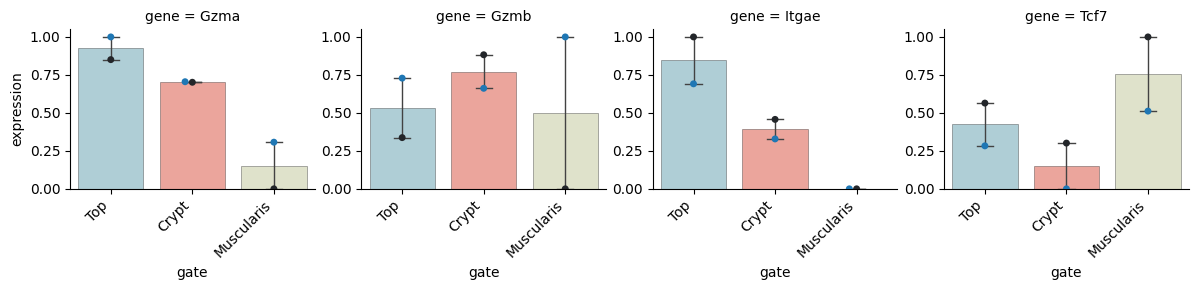

In [22]:
gate_palette = {
    "Top": "#3A9AB2",
    "Crypt": "#F11B00",
    "Muscularis": "#BDC881",
}

g = sns.FacetGrid(df, col="gene", col_wrap=4, sharey=False)
g.map_dataframe(
    sns.barplot,
    x="gate",
    y="expression",
    hue="gate",
    palette=gate_palette,
    alpha=0.44,
    capsize=0.2,
    edgecolor="black",
    linewidth=0.5,
    errwidth=1,
)
g.set_xticklabels(rotation=45, ha="right")
g.map_dataframe(sns.swarmplot, x="gate", y="expression", hue="batch")

In [23]:
print(df.shape)
print(df["gate"].unique())

(24, 6)
['Crypt', 'Muscularis', 'Top']
Categories (3, object): ['Top' < 'Crypt' < 'Muscularis']


Skipping missing genes: ['Cxcr6', 'Gzmk', 'Tbx21']


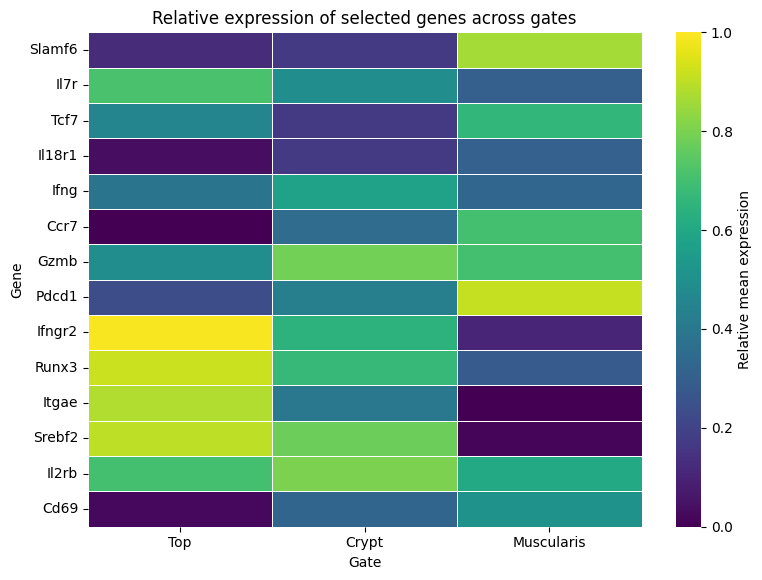

In [ ]:
# Matrix plot of relative expression across gates for selected genes
genes_of_interest = [
    "Slamf6",
    "Il7r",
    "Tcf7",
    "Il18r1",
    "Ifng",
    "Ccr7",
    "Gzmb",
    "Gzmk",
    "Pdcd1",
    "Tbx21",
    "Ifngr2",
    "Cxcr6",
    "Runx3",
    "Itgae",
    "Srebf2",
    "Il2rb",
    "Cd69",
]

available_genes = [g for g in genes_of_interest if g in adata.var_names]
missing_genes = sorted(set(genes_of_interest) - set(available_genes))
if missing_genes:
    print(f"Skipping missing genes: {missing_genes}")

# Scaled mean expression by gate (scaled within each gene)
df_panel = get_scaled_mean_expression(adata, available_genes)
# Drop very small groups to reduce noise
df_panel = df_panel[df_panel["group_size"] >= 10]

# Weighted average per gene/gate using group size as weight
df_gate_mean = (
    df_panel.groupby(["gene", "gate"])
    .apply(lambda g: np.average(g["expression"], weights=g["group_size"]))
    .reset_index(name="expression")
)

heatmap_data = df_gate_mean.pivot(index="gene", columns="gate", values="expression")
heatmap_data = heatmap_data.reindex(index=available_genes, columns=gate_order)

plt.figure(figsize=(8, 0.35 * len(available_genes) + 1))
sns.heatmap(
    heatmap_data,
    cmap="viridis",
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Relative mean expression"},
    vmin=0,
    vmax=1,
)
plt.xlabel("Gate")
plt.ylabel("Gene")
plt.title("Relative expression of selected genes across gates")
plt.tight_layout()
plt.show()

